# Hidden Markov Models

We explore a Bayesian extension of hidden markov models.

Some inspiration:

https://ericmjl.github.io/essays-on-data-science/machine-learning/markov-models/

(in particular, here: https://ericmjl.github.io/essays-on-data-science/machine-learning/markov-models/#hmm-distributions-in-pymc3)

and this:
https://www.pymc.io/projects/examples/en/latest/howto/wrapping_jax_function.html

we'll try our own way

In [1]:
from hmmlearn import hmm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import xarray as xr
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


#TODO: upgrade from theano tensor to torch
#https://stackoverflow.com/questions/77823789/bayesian-mmm-with-pytensor-in-place-of-theano
# theano not compatible with recent numpy

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import scipy

In [3]:
import pytensor.tensor as pt
from pytensor.tensor import slinalg

In [4]:
class run_hmm:

    def __init__(self):
        
        np.random.seed(42)
        self.t_len = 100
    def gen_data(self):
        self.model = hmm.CategoricalHMM(n_components=2)
        
        self.model.startprob_ = np.array([0.6, 0.4])
        
        # transmission matrix
        # two hidden states: 0 is off, 1 is on
        self.model.transmat_ = np.array([[0.95, 0.05], # state 0 to states 0, 1
        
                                    [0.01, 0.99]]) # states 1 to states 0, 1
        # emission matrix
        # we'll code 3 states: detection, non-detection, no measurement
        
        no_measurement = 0.5
        detection_fraction_on = 0.5
        detection_fraction_off = 0.1
        self.model.emissionprob_ = np.array([[(1-no_measurement)*(1-detection_fraction_off), (1-no_measurement)*(detection_fraction_off), no_measurement],
                                       [(1-no_measurement)*(1-detection_fraction_on), (1-no_measurement)*(detection_fraction_on), no_measurement]])
        
        self.observations, self.hidden_states = self.model.sample(self.t_len)
        self.obs = self.observations.flatten()
        self.obs = self.obs.astype('float')
        self.obs[self.obs==2] = np.nan

    def fit_data(self, emissions_guess=None, transmission_guess=None):
        self.fitted_model = hmm.CategoricalHMM(n_components=2)
        if emissions_guess is not None:
            self.fitted_model.emissionprob_ = emissions_guess
        if transmission_guess is not None:
            self.fitted_model.transmat_ = transmission_guess
        self.inferred_hidden_states = self.fitted_model.fit(self.observations)
        self.inferred_hidden_states = self.fitted_model.predict(self.observations)
        

    def plot_data(self):
        plt.scatter(np.arange(self.t_len), self.obs, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0],alpha=0.5, label='observations')
        plt.plot(np.arange(self.t_len), self.hidden_states, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], label='hidden state')
        #plt.plot(np.arange(self.t_len), self.inferred_hidden_states, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2], alpha=0.3,linestyle='--',label='inferred hidden state')
        plt.legend()
        plt.title('HMM Hidden State (On/Off) and Observations (Detect / Non-Detect) with Missing Data')
        return

In [5]:
hmm_data = run_hmm()
hmm_data.gen_data()

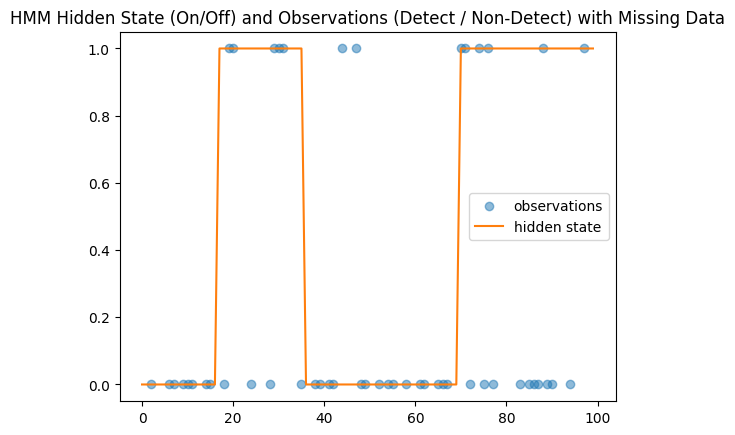

In [6]:
hmm_data.plot_data()

In [7]:
hmm_data.model.emissionprob_

array([[0.45, 0.05, 0.5 ],
       [0.25, 0.25, 0.5 ]])

In [8]:
hmm_data.model.transmat_

array([[0.95, 0.05],
       [0.01, 0.99]])

In [ ]:
with pm.Model() as hmm_model:
    hmm_model.add_coords({"obs_id": range(hmm_data.t_len)})
    time = pm.MutableData("t",range(hmm_data.t_len) , dims="obs_id")
    vals = pm.MutableData("obs", hmm_data.observations.flatten().as_type('float'), dims="obs_id")

    emissions = pm.Dirichlet("emissions", np.array([[1,1,1],[1,1,1]), shape=(2,3))
    transmissions = pm.Dirichlet("transmissions", np.array([[1,1,1],[1,1,1]], shape=(2,3))

    

ok, this is looking a lot harder than I thought it would. Both tutorials use a lot of complexity and I'm seeing why it's necessary. 


### Approach

We'll follow the first tutorial linked above, which is excellent. We replicate the relevant parts and talk through them.

First we define our states. In this case we have two, on and off.
Next our goal is to generate a function that computes the likelihood of a set of states. That's easy enough--for a given chain of states we need the probability of the initial state times the probability of it transitioning to the next state, and so on:

In [8]:
from scipy.stats import multinomial
from typing import List


In [9]:
def state_logp(states, p_transition):
    logp = 0

    states_oh = np.eye(len(p_transition))
    for curr_state, next_state in zip(states[:-1], states[1:]):
        p_tr = p_transition[curr_state]
        logp += multinomial(n=1, p=p_tr).logpmf(states_oh[next_state])
    return logp

state_logp(states = [0,1,1,0,0,1], p_transition=hmm_data.model.transmat_)

-10.657978363337122

though in this case we could do one simpler:

In [10]:
def state_logp(states, p_transition):
    logp = 0

    # states are 0, 1, 2, but we model them as [1, 0, 0], [0, 1, 0], [0, 0, 1]
    states_oh = np.eye(len(p_transition))
    for curr_state, next_state in zip(states[:-1], states[1:]):
        p = p_transition[curr_state][next_state]
        logp += np.log(p)
    return logp

state_logp(states = [0,1,1,0,0,1], p_transition=hmm_data.model.transmat_)

-10.657978363337124

### Vectorization

Their vectorized version of the loop. It's worthwhile to take a look at the pieces, vectorization can get a little confusing.

In [11]:
def state_logp_vect(states, p_transition):
    states_oh = np.eye(len(p_transition))
    p_tr = p_transition[states[:-1]]
    obs = states_oh[states[1:]]
    return multinomial(n=1, p=p_tr).logpmf(obs), obs #np.sum(multinomial(n=1, p=p_tr).logpmf(obs))

state_logp_vect(states=[0,1,1,0,0,1], p_transition=hmm_data.model.transmat_)

(array([-2.99573227, -0.01005034, -4.60517019, -0.05129329, -2.99573227]),
 array([[0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.]]))

In [92]:
p_transition=hmm_data.model.transmat_
states=[0,1,1,0,0,1]

In [95]:
states[:-1]

[0, 1, 1, 0, 0]

In [93]:
p_transition[states[:-1]] # so from our indices, it pulls out corresponding rows of the transition matrix and stacks them

array([[0.95, 0.05],
       [0.01, 0.99],
       [0.01, 0.99],
       [0.95, 0.05],
       [0.95, 0.05]])

In [98]:
states[1:]

[1, 1, 0, 0, 1]

In [97]:
states_oh[states[1:]] # confusing that the states it pulls are vectors and not 0 or 1

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])

In [112]:
transitions = np.array(list(zip(states[:-1], states[1:])))
transitions

array([[0, 1],
       [1, 1],
       [1, 0],
       [0, 0],
       [0, 1]])

In [12]:
def state_logp_vect(states, p_transition):
    states_oh = np.eye(len(p_transition))
    p_tr = p_transition[states[:-1]]
    obs = states_oh[states[1:]]
    return np.sum(multinomial(n=1, p=p_tr).logpmf(obs))

state_logp_vect(states=[0,1,1,0,0,1], p_transition=hmm_data.model.transmat_)

-10.657978363337122

### Putting it into PymC


#### SolveEquilibrium?

We're getting the equilibrium distribution by asking the question: if we hit the state vector with the transition matrix infinite times where would it converge to? This is the same as asking what the eigenvector of the transition matrix is, because that's what has this property.

So if Ax = x
then (A-I)x=0
that's the basic insight
I think



In [ ]:
# original in theano which we're not using
def solve_equilibrium(n_states, p_transition):
    A = tt.dmatrix('A')
    A = tt.eye(n_states) - p_transition + tt.ones(shape=(n_states, n_states))
    p_equilibrium = pm.Deterministic("p_equilibrium", sla.solve(A.T, tt.ones(shape=(n_states))))
    return p_equilibrium

In [24]:
np.ones(shape=(3))

array([1., 1., 1.])

In [34]:
def solve_equilibrium(n_states, p_transition):
    A = np.eye(n_states) - p_transition + np.ones(shape=(n_states, n_states))
    p_equil = scipy.linalg.solve(A.T, np.ones(shape=(n_states)))
    return p_equil

array([0.16666667, 0.83333333])

In [45]:
def test_np_solve_equilibrium(n_states, p_transition):
    A = np.eye(n_states) - p_transition + np.ones(shape=(n_states, n_states))
    p_equil = scipy.linalg.solve(A.T, np.ones(shape=(n_states)))
    #p_equilibrium = pm.Deterministic("p_equilibrium", p_equil)
    return p_equil

In [46]:
test_np_solve_equilibrium(2,hmm_data.model.transmat_)

array([0.16666667, 0.83333333])

In [50]:
def test_solve_equilibrium(n_states, p_transition):
    A = pt.eye(n_states) - p_transition + pt.ones(shape=(n_states, n_states))
    p_equil = slinalg.solve(A.T, pt.ones(shape=(n_states)))
    #p_equilibrium = pm.Deterministic("p_equilibrium", p_equil)
    return p_equil

In [51]:
test_solve_equilibrium(2,hmm_data.model.transmat_) 

Blockwise{Solve{assume_a='gen', lower=False, check_finite=True, b_ndim=1}, (m,m),(m)->(m)}.0

In [9]:
def solve_equilibrium(n_states, p_transition):
    A = pt.eye(n_states) - p_transition + pt.ones(shape=(n_states, n_states))
    p_equil = slinalg.solve(A.T, pt.ones(shape=(n_states)))
    p_equilibrium = pm.Deterministic("p_equilibrium", p_equil)
    return p_equilibrium

In [23]:
#TODO: show that this implementation runs
# currently it's broken! when importing pm.Categorical we're required to pass either p or logit_p, not log_p
# this must be because it was allowable back when the tutorial was written, just as theano was compatible then too
# but times have changed and I'm pretty sure this HMMStates class doesn't work anymore

class HMMStates(pm.Categorical):
    def __init__(self, p_transition, p_equilibrium, n_states, *args, **kwargs):
        """You can ignore this section for the time being."""
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.p_transition = p_transition
        self.p_equilibrium = p_equilibrium
        # This is needed
        self.k = n_states
        # This is only needed because discrete distributions must define a mode.
        self.mode = pt.cast(0,dtype='int64')

    def logp(self, x):
        """Focus your attention here!"""
        p_eq = self.p_equilibrium
        # Broadcast out the transition probabilities,
        # so that we can broadcast the calculation
        # of log-likelihoods
        p_tr = self.p_transition[x[:-1]]

        # the logp of the initial state evaluated against the equilibrium probabilities
        initial_state_logp = pm.Categorical.dist(p=p_eq).logp(x[0])

        # the logp of the rest of the states.
        x_i = x[1:]
        ou_like = pm.Categorical.dist(p=p_tr).logp(x_i)
        transition_logp = pt.sum(ou_like)
        return initial_state_logp + transition_logp

        

In [24]:
n_states = 2
states=[0,1,1,0,0,1]

with pm.Model() as model:
    p_transition = pm.Dirichlet(
        "p_transition",
        a=pt.ones((n_states, n_states)) * 4,  # weakly informative prior
        shape=(n_states, n_states))

    # Solve for the equilibrium state
    p_equilibrium = solve_equilibrium(n_states, p_transition)

    obs_states = HMMStates(
        "states",
        p_transition=p_transition,
        p_equilibrium=p_equilibrium,
        n_states=n_states,
        observed=np.array(states).astype("float")
    )

ValueError: Incompatible parametrization. Must specify either p or logit_p.

# Notebook State

So currently, our progress is halted. We have a hard requirement when inheriting from the pm.Categorical class to pass a p or logit_p, not logp. To overcome this we have to do some very deep digging into pymc3, which is possible but will take more time.

In [16]:
#GRAVEYARD

#attempts to fix HMMStates

class HMMStates():
    def __init__(self, p_transition, p_equilibrium, n_states, *args, **kwargs):
        """You can ignore this section for the time being."""
        self.p_transition = p_transition
        self.p_equilibrium = p_equilibrium
        # This is needed
        self.k = n_states
        # This is only needed because discrete distributions must define a mode.
        self.mode = pt.cast(0,dtype='int64')

    def logp(self, x):
        """Focus your attention here!"""
        p_eq = self.p_equilibrium
        # Broadcast out the transition probabilities,
        # so that we can broadcast the calculation
        # of log-likelihoods
        p_tr = self.p_transition[x[:-1]]

        # the logp of the initial state evaluated against the equilibrium probabilities
        initial_state_logp = pm.Categorical.dist(p=p_eq).logp(x[0])

        # the logp of the rest of the states.
        x_i = x[1:]
        ou_like = pm.Categorical.dist(p=p_tr).logp(x_i)
        transition_logp = pt.sum(ou_like)
        return initial_state_logp + transition_logp


class HMMStates(pm.Discrete):
    def __init__(self, p_transition, p_equilibrium, n_states, *args, **kwargs):
        """You can ignore this section for the time being."""
        super(pm.Discrete, self).__init__(*args, **kwargs)
        self.p_transition = p_transition
        self.p_equilibrium = p_equilibrium
        # This is needed
        self.k = n_states
        # This is only needed because discrete distributions must define a mode.
        self.mode = pt.cast(0,dtype='int64')

    def logp(self, x):
        """Focus your attention here!"""
        p_eq = self.p_equilibrium
        # Broadcast out the transition probabilities,
        # so that we can broadcast the calculation
        # of log-likelihoods
        p_tr = self.p_transition[x[:-1]]

        # the logp of the initial state evaluated against the equilibrium probabilities
        initial_state_logp = pm.Categorical.dist(p=p_eq).logp(x[0])

        # the logp of the rest of the states.
        x_i = x[1:]
        ou_like = pm.Categorical.dist(p=p_tr).logp(x_i)
        transition_logp = pt.sum(ou_like)
        return initial_state_logp + transition_logp

        

In [ ]:
class HMMCategoricalEmissions(pm.Categorical):
    def __init__(self, states, p_emissions, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.states = states
        # self.rate = rate
        #self.mu = mu
        #self.sigma = sigma

        self.p_emissions = p_emissions

    def logp(self, x):
        """
        x: observations
        """
        states = self.states
        
        # rate = self.rate[states]  # broadcast the rate across the states.
        #TODO: instead of getting mu and sigma, get the emissions probabilities
        
       ## mu = self.mu[states]
       ## sigma = self.sigma[states]
       ## return tt.sum(pm.Normal.dist(mu=mu, sigma=sigma).logp(x))

        

In [ ]:
n_states = 2
n_emission_vals = 3
with pm.Model() as model:
    # Priors for transition matrix
    p_transition = pm.Dirichlet("p_transition", a=np.ones((n_states, n_states)), shape=(n_states, n_states))
    p_emission = pm.Dirichlet("p_emission", a=np.ones((n_states, n_emissions_vals)), shape=(n_states, n_emissions_vals))
                                 
    # Solve for the equilibrium state
    p_equilibrium = solve_equilibrium(n_states, p_transition)

    # HMM state
    hmm_states = HMMStates(
        "hmm_states",
        p_transition=p_transition,
        p_equilibrium=p_equilibrium,
        n_states=n_states,
        shape=(len(gaussian_ems),)
    )

    # Now instead of the gaussian emissions in the example
    # we'll create a function that, for a given state vector and given emissions, computes the likelihood of those emissions
    # just like HMMStates logp calculates the likelihood of a given state vector
    # but is it necessary to use HMMCategoricalEmissions class? Couldn't you just pass the hmm_states as 
    
    
    obs = HMMCategoricalEmissions(
        "emission",
        states=hmm_states,
        p_emissions = p_emissions,
        observed=gaussian_ems)

# try replacing it with something like:
    # obs = pm.Categorical("data_likelihood", p = p_emission[states])

In [ ]:
# unmodified version
n_states = 3

class HMMGaussianEmissions(pm.Continuous):
    def __init__(self, states, mu, sigma, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.states = states
        # self.rate = rate
        self.mu = mu
        self.sigma = sigma

    def logp(self, x):
        """
        x: observations
        """
        states = self.states
        # rate = self.rate[states]  # broadcast the rate across the states.
        mu = self.mu[states]
        sigma = self.sigma[states]
        return tt.sum(pm.Normal.dist(mu=mu, sigma=sigma).logp(x))
        
with pm.Model() as model:
    # Priors for transition matrix
    p_transition = pm.Dirichlet("p_transition", a=tt.ones((n_states, n_states)), shape=(n_states, n_states))

    # Solve for the equilibrium state
    p_equilibrium = solve_equilibrium(n_states, p_transition)

    # HMM state
    hmm_states = HMMStates(
        "hmm_states",
        p_transition=p_transition,
        p_equilibrium=p_equilibrium,
        n_states=n_states,
        shape=(len(gaussian_ems),)
    )

    # Prior for mu and sigma
    mu = pm.Normal("mu", mu=0, sigma=1, shape=(n_states,))
    sigma = pm.Exponential("sigma", lam=2, shape=(n_states,))

    # Observed emission likelihood
    obs = HMMGaussianEmissions(
        "emission",
        states=hmm_states,
        mu=mu,
        sigma=sigma,
        observed=observed_data
    )


In [ ]:
## model after this
